### SYSNET Backward Feature Elimination Tutorial

This tutorial is meant to follow the `demo_decalsdr7.ipynb` tutorial and the chains tutorial.

Feature elimination is used by sysnet to remove redundant input information. Removing the features that contribute the least to the model output, or the features that make the model output worse, reduces noise and helps prevent the model from overfitting to the training data. 

In order to do feature elimination, sysnet will do a linear regression to find the root mean squared error (RMSE) of the current features as a baseline. Then, it will remove one feature and find the RMSE for the model without that feature. It repeats this process for each feature to find which feature's removal will decrease the error the most (or increase the error the least). 

#### Outline For Using Feature Elimination
1. Turn on feature elimination from the config file
2. Run the pipeline. If removing individual feature would cause the model to improve (the error to decrease), remove that feature from the model's axes
3. Rerun feature elimination on the new axes.
4. Repeat steps 2 and 3 until removing any feature causes the model's error to increase
3. Train the model with the axes containing all of the features that haven't been eliminated


columns in `input`: [('label', '>f8'), ('hpix', '>i8'), ('features', '>f8', (18,)), ('fracgood', '>f8')]


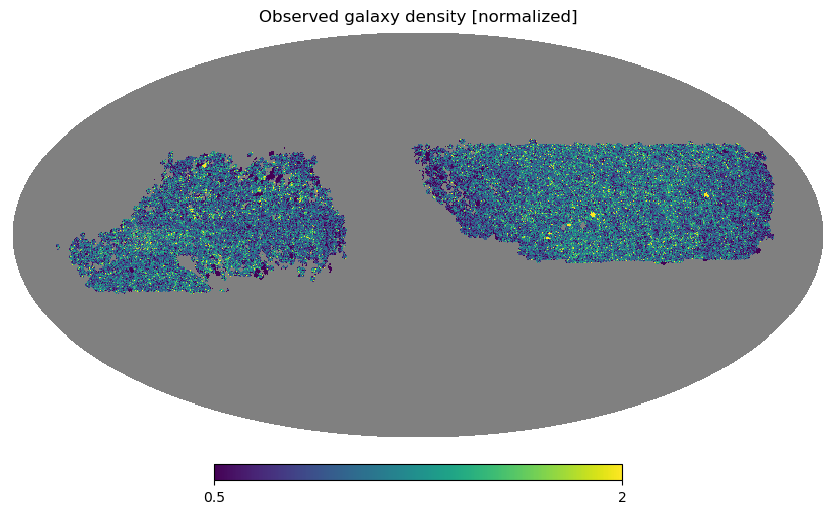

In [1]:
# importing general Python modules
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# importing SYSNET modules
# add the absolute path to 'sysnetdev'
home = os.getenv('HOME')
#sys.path.append(f'{home}/Github/sysnetdev')
sys.path.append(f'{home}/Documents/Github/sysnetdev')


from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

input_path = '../input/eBOSS.ELG.NGC.DR7.table.fits'

# tabulated catalog that contains, imaging properties (features), galaxy counts (label), 
# HEALPix index (hpix), and pixel completeness (fracgood)
#input_ = ft.read('../input/eBOSS.ELG.NGC.DR7.table.fits')  # read tab. data
input_ = ft.read(input_path) 
print(f'columns in `input`: {input_.dtype}')
num_features = len(input_["features"][0])

# repackage hpix and label to a HEALPix map for visualization purpose    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']    

# Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2.0,
            title='Observed galaxy density [normalized]')

#### 1. Edit the config file

Sysnet takes its input variables from a config file: `config.yaml`.
To use feature elimination, set "do_rfe" to true.

In [3]:
# Edit the config file
config = Config('../scripts/config.yaml')

# Set the config file parameters
# These are the parameters used by the demo NN in the demo_decalsdr7.ipynb notebook
config.update('nepochs', 70) # 70 epochs of training per chain
config.update('axes', [i for i in range(num_features)]) # Start with all of the features
config.update('batch_size', 4096)
config.update('input_path', input_path)
config.update('output_path', '../output/rfe_demo')
config.update('learning_rate', 0.01) # Learning rate
config.update('do_rfe', True) # Turn on rfe

config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/rfe_demo',
 'restore_model': None,
 'batch_size': 4096,
 'nepochs': 70,
 'nchains': 1,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnnp',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'do_rfe': True,
 'eta_min': 1e-05,
 'learning_rate': 0.01,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'pnll',
 'no_eval': False}

#### 2. Run the Sysnet Pipeline

In [4]:
pipeline = SYSNet(config)
pipeline.run()

logging in ../output/rfe_demo/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/rfe_demo
restore_model: None
batch_size: 4096
nepochs: 70
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnnp
optim: adamw
scheduler: cosann
axes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
do_rfe: True
eta_min: 1e-05
learning_rate: 0.01
nn_structure: [4, 20]
l1_alpha: -1.0
loss: pnll
no_eval: False
loss_kwargs: {'log_input': False, 'reduction': 'none'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.022 s
# of data: 187257
updated axes to [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
data loaded in 0.087 sec
# running pipeline ...
# running rfe ...
all attributes with 0.12689

SystemExit: rfe done...rerun the code without --do_rfe

/Users/sambringman/miniconda3/envs/sysnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


When I ran the above cell, the root mean squared error with all attributes is 0.126893. The output of the cell above should show the RMSE of all attributes, and then the RMSEs of a model that has one of the features removed. It does this for each axis, and at the end outputs a list of feature axes that does would decrease the RMSE the most (or increase it the least, if the removal of any feature would increase the error). Here, removing attribute 5 decreases the error to 0.126892, so the axes list at the bottom doesn't include feature 5.

Note that the order of the axis list does not matter, only what indices are contained in the list.

Now, we'll run the same pipeline again, but with the new feature list. We'll continue doing this until removing any feature would make the model worse.

#### 3. Rerun FE on the new axes

In [5]:
config.update('axes', [13, 6, 15, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]) # New axes

pipeline = SYSNet(config)
pipeline.run()

logging in ../output/rfe_demo/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/rfe_demo
restore_model: None
batch_size: 4096
nepochs: 70
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnnp
optim: adamw
scheduler: cosann
axes: [13, 6, 15, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]
do_rfe: True
eta_min: 1e-05
learning_rate: 0.01
nn_structure: [4, 20]
l1_alpha: -1.0
loss: pnll
no_eval: False
loss_kwargs: {'log_input': False, 'reduction': 'none'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.021 s
# of data: 187257
updated axes to [13, 6, 15, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]
data loaded in 0.086 sec
# running pipeline ...
# running rfe ...
all attributes with 0.126892
attr

SystemExit: rfe done...rerun the code without --do_rfe

The next feature to be removed is feature 13. Removing 13 doesn't make the model worse, and removing it will help reduce noise and prevent overfitting.

#### 4. Repeat Until the Model Stops Improving

In [6]:
config.update('axes', [15, 6, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]) # New axes

pipeline = SYSNet(config)
pipeline.run()

logging in ../output/rfe_demo/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/rfe_demo
restore_model: None
batch_size: 4096
nepochs: 70
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnnp
optim: adamw
scheduler: cosann
axes: [15, 6, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]
do_rfe: True
eta_min: 1e-05
learning_rate: 0.01
nn_structure: [4, 20]
l1_alpha: -1.0
loss: pnll
no_eval: False
loss_kwargs: {'log_input': False, 'reduction': 'none'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.019 s
# of data: 187257
updated axes to [15, 6, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]
data loaded in 0.119 sec
# running pipeline ...
# running rfe ...
all attributes with 0.126892
attribute in

SystemExit: rfe done...rerun the code without --do_rfe

Now, removing the next worst feature, feature 15, would increase the error from 0.126892 to 0.126897. So, we keep all the remaining features.

Now, we turn off do_rfe and train the model on the best axes.

In [16]:
config.update('do_rfe', False) # New axes

pipeline = SYSNet(config)
pipeline.run()

logging in ../output/rfe_demo/train.log
# --- inputs params ---
input_path: ../input/eBOSS.ELG.NGC.DR7.table.fits
output_path: ../output/rfe_demo
restore_model: None
batch_size: 4096
nepochs: 70
nchains: 1
find_lr: False
find_structure: False
find_l1: False
do_kfold: False
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnnp
optim: adamw
scheduler: cosann
axes: [15, 6, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.01
nn_structure: [4, 20]
l1_alpha: -1.0
loss: pnll
no_eval: False
loss_kwargs: {'log_input': False, 'reduction': 'none'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.023 s
# of data: 187257
updated axes to [15, 6, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2]
data loaded in 0.138 sec
# running pipeline ...
# training and evaluation
partition_0 with (4, 20, 16, 1)


#### 5. Train and Forward the Reduced Model

In [2]:
name_model = 'dnnp'

# Create model object with the appropriate number of features
# The rfe model has only 16 features, since we removed two
tm_rfe = TrainedModel(name_model, '../output/rfe_demo/model_0_2664486226/best.pth.tar', nnstruct=(4, 20), num_features=16)
tm_demo = TrainedModel(name_model, '../output/demo_model/model_0_2664486226/best.pth.tar', nnstruct=(4, 20), num_features=18)

# Forward model with the appropriate number of axes
# Use all axes for the demo model, and only the best axes for the rfe model
hpix, nn_labels_rfe = tm_rfe.forward(input_path, axes=[15, 6, 4, 3, 8, 11, 17, 14, 9, 0, 12, 7, 16, 10, 1, 2])
hpix, nn_labels_demo = tm_demo.forward(input_path, axes=[i for i in range(num_features)])

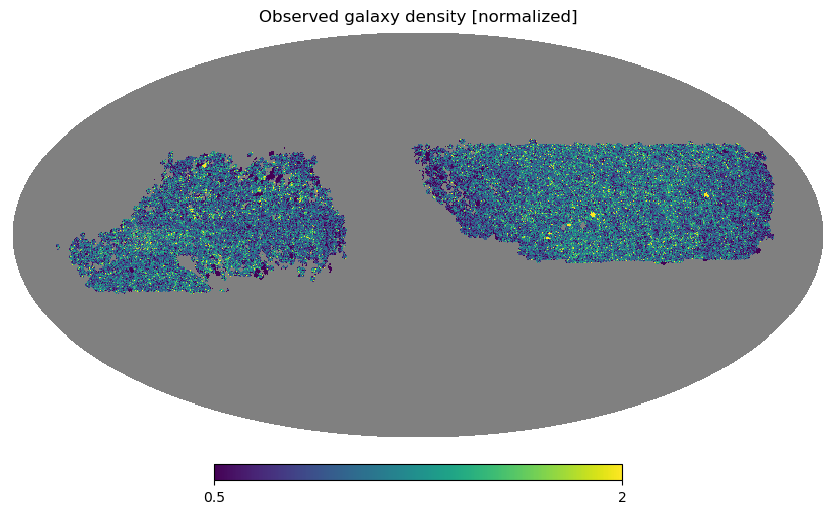

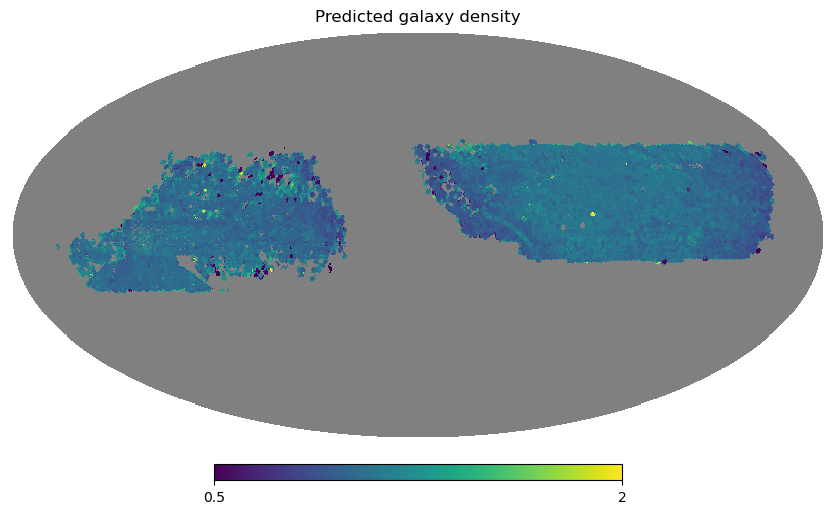

In [3]:
# We can compare visually the output of all chains combined
# Note that the model output is much smoother.
nside = 256

# Raw Data
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng[input_['hpix']] = input_['label']

# Feature Reduction NN
ng_ = np.zeros(12*nside*nside)
ng_[:] = np.nan
ng_[hpix] = nn_labels_rfe

# Raw Mollweide projection
hp.mollview(ng, rot=-85, min=0.5, max=2,
            title='Observed galaxy density [normalized]')

# NN Mollweide projection
hp.mollview(ng_, rot=-85, min=0.5, max=2,
            title='Predicted galaxy density')

In [8]:
def plot_feature(features, ngal, nran, num_bins, ax,  **kwargs):
    """Plots the mean number densities as a function of a systematic.
    Uses equal area binning, so each bin has the same amount of pixels in it."""
    
    num_pixels = len(features)

    # Sort the features to find where to put the bin edges to get an equal number of 
    # pixels per bin.
    sorted_features = np.sort(features)
    bin_edges = np.array([sorted_features[i*num_pixels//num_bins] for i in range(num_bins)])
    bin_edges = np.append(bin_edges, sorted_features[-1])

    # Weighting by the nran, ngal counts the number of galaxies in each bin
    rands, bins = np.histogram(features, bins=bin_edges, weights=nran)
    data, bins = np.histogram(features, bins, weights=ngal)

    # The normalization factor
    norm_factor = sum(rands)/sum(data)

    # Applyign the normalization factor
    normed_vals = (data/rands) * norm_factor
    
    # The x value of the plot is for the center of the bin
    bin_centers = (bins[1:]+bins[:-1])/2.0

    # Make the plots
    ax.plot(bin_centers, normed_vals, **kwargs)
    ax.errorbar(bin_centers, normed_vals, 0.01, **kwargs)
    return

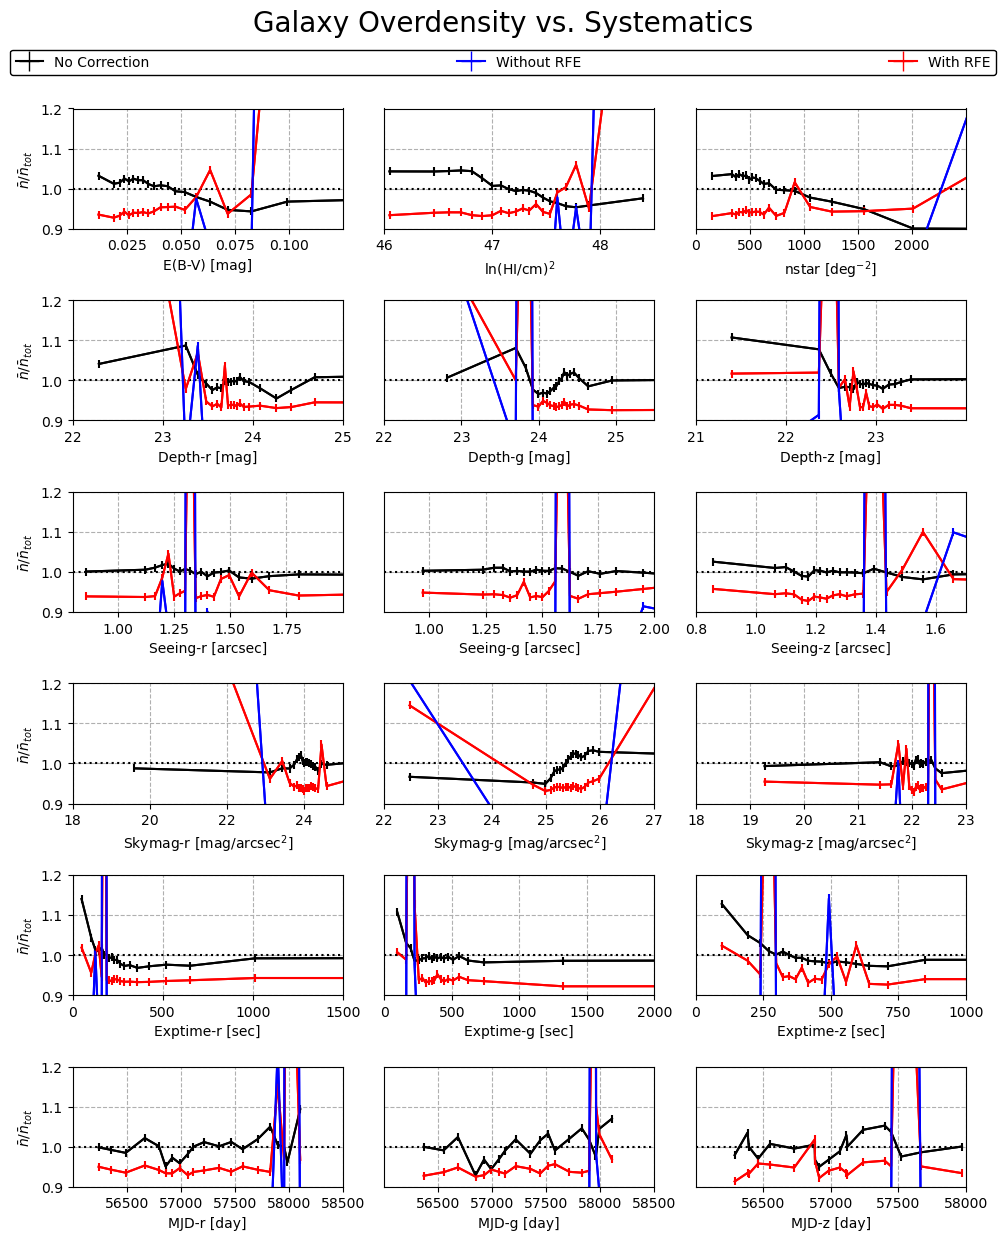

In [ ]:
# Transpose the features list so that the for loops
# can iterate through the features
features = np.array(input_["features"]).T

# Number of bins in the histogram
num_bins = 20

# These are all plotting variables
legend_handles = []

left_x_lim = [[0, 46, 0],
              [22, 22, 21],
              [0.8, 0.8, 0.8],
              [18, 22, 18],
              [0, 0, 0],
              [56000, 56000, 56000],
              ]

right_x_lim = [[0.125, 48.5, 2500],
              [25, 25.5, 24],
              [2, 2, 1.7],
              [25, 27, 23],
              [1500, 2000, 1000],
              [58500, 58500, 58000],
              ]

x_labels = [["E(B-V) [mag]", r"ln(HI/cm)$^2$", r"nstar [deg$^{-2}$]"],
              ["Depth-r [mag]", "Depth-g [mag]", "Depth-z [mag]"],
              ["Seeing-r [arcsec]", "Seeing-g [arcsec]", "Seeing-z [arcsec]"],
              [r"Skymag-r [mag/arcsec$^2$]", r"Skymag-g [mag/arcsec$^2$]", r"Skymag-z [mag/arcsec$^2$]"],
              ["Exptime-r [sec]", "Exptime-g [sec]", "Exptime-z [sec]"],
              ["MJD-r [day]", "MJD-g [day]", "MJD-z [day]"],
              ]

axvline_vals = [[[0.025, 0.050, 0.075, 0.100], [46.0, 47.0, 48.0], [0, 500, 1000, 1500, 2000]],
              [[22, 23, 24, 25], [22, 23, 24, 25], [21, 22, 23]],
              [[1.0, 1.25, 1.5,  1.75], [1.0, 1.25, 1.5, 1.75, 2.0], [0.8, 1.0, 1.2, 1.4, 1.6]],
              [[18, 20, 22, 24], [22, 23, 24, 25, 26, 27], [18, 19, 20, 21, 22, 23]],
              [[0, 500, 1000, 1500], [0, 500, 1000, 1500, 2000], [0, 250, 500, 750, 1000]],
              [[56500, 57000, 57500, 58000, 58500], [56500, 57000, 57500, 58000, 58500], [56500, 57000, 57500, 58000]],
              ]


# Create the Figure object
fig, axs = plt.subplots(6, 3, sharey='row', figsize=(10, 12))

# Loop through each graph and plot the appropriate features and labels
for i in range(6):
    for j in range(3):

        feature_num = j + i*3

        # Plot the raw data and the nn model outputs
        # We divide the input labels by the NN outputs to get the galaxy predicted
        # by sysnet
        plot_feature(features[feature_num], input_["label"], input_["fracgood"], 20, axs[i, j], c="k")
        plot_feature(features[feature_num], input_["label"] / nn_labels_rfe, input_["fracgood"], 20, axs[i, j], c="r")
        plot_feature(features[feature_num], input_["label"] / nn_labels_demo, input_["fracgood"], 20, axs[i, j], c="b")

        # Set plotting variables
        axs[i, j].grid(linestyle="--")
        axs[i, j].set_xlim(left_x_lim[i][j], right_x_lim[i][j])
        axs[i, j].set_ylim(0.9, 1.2)
        axs[i, j].axhline(y=1, c="k", linestyle=":")
        axs[i, j].set_xlabel(x_labels[i][j])
        axs[i, j].set_xticks(axvline_vals[i][j])

        if j == 0:
            axs[i, j].set_ylabel(r"$\bar n / \bar n_{tot}$")
        else:
            axs[i, j].tick_params(left=False)

# Create the legend
raw_data_label = mlines.Line2D([], [], color='k', marker='+',
                          markersize=15, label='No Correction')

rfe_label = mlines.Line2D([], [], color='r', marker='+',
                          markersize=15, label='With RFE')

demo_label = mlines.Line2D([], [], color='b', marker='+',
                          markersize=15, label='Without RFE')


legend_handles.append(raw_data_label)
legend_handles.append(demo_label)
legend_handles.append(rfe_label)

fig.legend(handles=legend_handles, bbox_to_anchor=(0., 0.9, 1., .102), loc='upper center', 
           ncols=3, fancybox="False", mode='expand', framealpha=1, edgecolor="black")

fig.suptitle("Galaxy Overdensity vs. Systematics", fontsize="20", y = 1.03)
fig.tight_layout()
plt.show()